Running a PyTorch model over geospatial imagery
===

- QGIS, GeoTIFFs, GeoJSONs
- AWS S3
- PyTorch
- Raster Vision

---

# Setup

In [ ]:
%pip install --upgrade -q ipympl ipywidgets

!!! **Refresh the webpage here** !!!

We will be accessing files on S3 in this notebook. Since those files are public, we set the `AWS_NO_SIGN_REQUEST` to tell `rasterio` to skip the sign-in.

In [ ]:
%env AWS_NO_SIGN_REQUEST=YES

---

# GeoTIFFs and S3

In [ ]:
image_uri = 's3://azavea-research-public-data/raster-vision/examples/sample_images/sample-img-isprs-potsdam-ss.tif'

Download this image to inspect in QGIS: 

https://azavea-research-public-data.s3.amazonaws.com/raster-vision/examples/sample_images/sample-img-isprs-potsdam-ss.tif

---

In [ ]:
from rastervision.core.data import ClassConfig

class_config = ClassConfig(
    names=['Car', 'Building', 'Low Vegetation', 'Tree', 'Impervious', 'Clutter', 'null'],
)

# The model

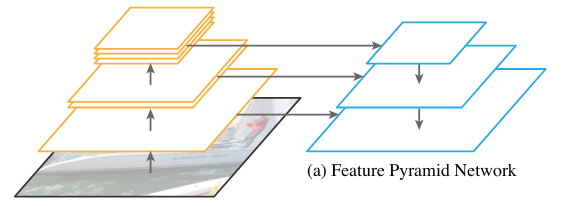

## Architecture and weights

The model architecture we are using here is a [panoptic FPN](https://arxiv.org/abs/1901.02446) with a [ResNet-18](https://arxiv.org/abs/1512.03385) backbone

The particular implementation we are using is from this repo: https://github.com/AdeelH/pytorch-fpn

Note how we use [TorchHub](https://pytorch.org/docs/stable/hub.html) to load the model from a GitHub repo. You can use it to pull model implementations from any repo that has a `hubconf.py` in its root directory.

In [ ]:
import torch

model = torch.hub.load(
    # github tag
    'AdeelH/pytorch-fpn:0.3',
    # entrypoint i.e. function defined in the repo that creates the model
    'make_fpn_resnet',
    # everything below is arguments passed to the entrypoint
    name='resnet50',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=256,
    in_channels=3,
    out_size=(256, 256),
    pretrained=False,
)

In [ ]:
model

In [ ]:
from torchvision.utils import make_grid
from matplotlib import pyplot as plt

first_conv_layer = model[0].m[0][0].weight.cpu()
grid = make_grid(first_conv_layer, normalize=True)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(grid.permute(1, 2, 0))
ax.axis('off')
plt.show()

### Load trained weights

In [ ]:
from rastervision.pipeline.file_system.utils import download_if_needed

model_weights_uri = 's3://azavea-research-public-data/raster-vision/examples/model-zoo-0.30/isprs-potsdam-ss/train/last-model.pth'
model_weights_path = download_if_needed(model_weights_uri)
model.load_state_dict(torch.load(model_weights_path, map_location='cpu'))

In [ ]:
first_conv_layer = model[0].m[0][0].weight.cpu()
grid = make_grid(first_conv_layer, normalize=True)
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(grid.permute(1, 2, 0))
ax.axis('off')
plt.show()

### Counting params

In [ ]:
print('#params: ', f'{sum(p.numel() for p in model.parameters()):,}')

---

# Predicting in chunks

- explain size and stride and out_size

In [ ]:
from rastervision.pytorch_learner import SemanticSegmentationSlidingWindowGeoDataset

ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=image_uri,
    image_raster_source_kw=dict(channel_order=[0, 1, 2]),
    size=300,
    stride=300,
    out_size=256,
)

In [ ]:
img = ds.scene.raster_source[:, :]

In [ ]:
%matplotlib widget

from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import animation

plt.close('all')
fig, ax = plt.subplots(figsize=(6, 6))

windows = list(sorted(ds.windows, key=lambda w: tuple(w)))

def data_gen():
    for i in range(40):
        yield i

def draw(i):
    ax.clear()
    ax.imshow(img)
    for w in windows[:i]:
        p = patches.Polygon(w.to_points(), color='darkred', fill=False)
        ax.add_patch(p)
    w = windows[i]
    p = patches.Polygon(w.to_points(), color='r', lw=2, fill=False)
    ax.add_patch(p)
    return [ax]

anim = animation.FuncAnimation(fig, draw, data_gen, repeat=False)

plt.show()

In [ ]:
from rastervision.pytorch_learner import (
    DataConfig, SemanticSegmentationLearner, SemanticSegmentationLearnerConfig)

In [ ]:
learner = SemanticSegmentationLearner(
    cfg=SemanticSegmentationLearnerConfig(
        data=DataConfig(class_config=class_config, img_sz=256)),
    model=model,
    training=False,
)

In [ ]:
from rastervision.core.data import SemanticSegmentationLabels

predictions = learner.predict_dataset(
    ds,
    raw_out=True,
    numpy_out=True,
    predict_kw=dict(out_shape=(300, 300)),
)

pred_labels = SemanticSegmentationLabels.from_predictions(
    ds.windows,
    predictions,
    smooth=True,
    extent=ds.scene.extent,
    num_classes=len(class_config),
    crop_sz=None,
)

# Visualizing predictions

In [ ]:
scores = pred_labels.get_score_arr(pred_labels.extent)
scores.shape

In [ ]:
plt.close('all')
fig, axs = plt.subplots(2, 3, figsize=(9, 6))
for i, (ax, class_name) in enumerate(zip(axs.flat, class_config.names[:6])):
    fig.tight_layout(w_pad=-2)
    ax.imshow(scores[i], cmap='plasma')
    ax.axis('off')
    ax.set_title(class_name)
plt.show()

In [ ]:
pred_labels.save(
    uri='data/isprs_potsdam/predictions_1/',
    crs_transformer=ds.scene.raster_source.crs_transformer,
    class_config=class_config,
)

---

# Smoothing out edge artifacts

In [ ]:
ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=image_uri,
    image_raster_source_kw=dict(channel_order=[0, 1, 2]),
    size=300,
    stride=150,
    out_size=256,
)

In [ ]:
crop_sz = 75

In [ ]:
%matplotlib widget

plt.close('all')
fig, ax = plt.subplots(figsize=(6, 6))

windows = list(sorted(ds.windows, key=lambda w: tuple(w)))

def data_gen():
    for i in range(60):
        yield i

def draw(i):
    ax.clear()
    ax.imshow(img)
    for w in windows[:i]:
        p = patches.Polygon(w.to_points(), color='black', fill=False)
        ax.add_patch(p)
        w = w.center_crop(crop_sz, crop_sz)
        p = patches.Polygon(w.to_points(), color='darkred', fill=False)
        ax.add_patch(p)
    w = windows[i]
    w = w.center_crop(crop_sz, crop_sz)
    p = patches.Polygon(w.to_points(), color='r', lw=2, fill=False)
    ax.add_patch(p)
    return [ax]

anim = animation.FuncAnimation(fig, draw, data_gen, repeat=False)

plt.show()

In [ ]:
predictions = learner.predict_dataset(
    ds,
    raw_out=True,
    numpy_out=True,
    predict_kw=dict(out_shape=(300, 300)),
)

pred_labels = SemanticSegmentationLabels.from_predictions(
    ds.windows,
    predictions,
    smooth=True,
    extent=ds.scene.extent,
    num_classes=len(class_config),
    crop_sz=crop_sz,
)

In [ ]:
scores = pred_labels.get_score_arr(pred_labels.extent)
scores.shape

In [ ]:
plt.close('all')
fig, axs = plt.subplots(2, 3, figsize=(9, 6))
for i, (ax, class_name) in enumerate(zip(axs.flat, class_config.names[:6])):
    fig.tight_layout(w_pad=-2)
    ax.imshow(scores[i], cmap='plasma')
    ax.axis('off')
    ax.set_title(class_name)
plt.show()

In [ ]:
pred_labels.save(
    uri='data/isprs_potsdam/predictions_2/',
    crs_transformer=ds.scene.raster_source.crs_transformer,
    class_config=class_config,
)